In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV as RidgeClassifier
from sklearn.pipeline import make_pipeline

from sktime.transformations.panel.rocket import Rocket

import pandas as pd

In [2]:
path = "/Users/nraman/Documents/thesis_videos/"

lower = [76, 77, 90, 180, 85, 16, 315, 404, 320, 307]

upper = [184, 74, 73, 72, 11, 302, 303, 304, 408, 306]

u2 = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409]
l2 = [291, 375, 321, 405, 314, 17, 84, 181, 91, 146]

u3 = [57, 186, 92, 165, 167, 164, 393, 391, 322, 410]
l3 = [287, 273, 335, 406, 313, 18, 83, 182, 106, 43]

combo_indices = lower + upper + u2 + l2 + u3 + l3

In [3]:
subfolders = [i for i in os.listdir(path) if ".mp4" not in i and ".DS_Store" not in i and "12_" not in i]

def find_pointfolder(subfolder, path = "/Users/nraman/Documents/thesis_videos/"):
    cur_path = f"{path}{subfolder}"
    # get names of files within the subfolder
    subfiles = os.listdir(f"{path}{subfolder}")
    nps = [i for i in subfiles if ".npy" in i]
    
    if(len(nps) > 1):
        return("Error: Multiple np arrays saved in the folder")
    else:
        array = np.load(f"{cur_path}/{nps[0]}")
        array = array[:, combo_indices]
        return(array.reshape(array.shape[0], len(combo_indices)*2))

In [4]:
ground_folders = [i for i in subfolders if "ground" in i]
speak_folders = [i for i in subfolders if "ground" not in i]

ground_data = []
speak_data = []

for g in ground_folders:
    ground_data.append(find_pointfolder(g))

for s in speak_folders:
    speak_data.append(find_pointfolder(s))

In [5]:
#pd.DataFrame(eval([speak_data[0][:, i] for i in range(len(combo_indices))]))
trainsize = len(ground_data) + len(speak_data)
trainplus = len(speak_data)
window = 12

df=pd.DataFrame(np.zeros([trainsize, len(combo_indices)*2]))
df=df.astype(object)  # this line allows the signment of the array

for j in range(trainsize):
    for a in range(len(combo_indices)*2):
        if(j < trainplus):
            cur = speak_data[j][:, a]
            df.iloc[j, a] = pd.Series(cur[-window:])
        else:
            it = j-trainplus
            cur = ground_data[it][:, a]
            df.iloc[j, a] = pd.Series(cur[:window])

In [6]:
# testsize = 20
# testplus = 7
# buffer = 12*(trainsize - trainplus)

# testX=pd.DataFrame(np.zeros((testsize, len(combo_indices)*2))).astype(object)

# for j in range(testsize):
#     for a in range(len(combo_indices)*2):
#         if(j < testplus):
#             testX.iloc[j, a] = pd.Series(speak_data[-j][:, a][:12])
#         else:
#             testX.iloc[j, a] = pd.Series(ground_data[(j-testplus)*12 + buffer: ((j-testplus)+1)*12 + buffer][:, a])

In [7]:
ytrain = np.concatenate([np.ones(trainplus), np.zeros(trainsize - trainplus)])
#ytest = np.concatenate([np.ones(testplus), np.zeros(testsize - testplus)])

In [8]:
# df is for training
#train_y = np.concatenate([np.ones(30), np.zeros(30)])

rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(df)
X_train_transform = rocket.transform(df)

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

classifier = LDA()#RidgeClassifier(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, ytrain)

LinearDiscriminantAnalysis()

In [54]:
print(classifier.predict(rocket.transform(df)))
print(ytrain)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
# NEW DATA!!!

testsubfolders = [i for i in os.listdir(path) if "12_" in i and ".DS_Store" not in i and "MOV" not in i]

testground = [i for i in testsubfolders if "ground" in i]
testspeak = [i for i in testsubfolders if "ground" not in i]

In [56]:
ground2 = []
speak2 = []

for g in testground:
    ground2.append(find_pointfolder(g))

for s in testspeak:
    speak2.append(find_pointfolder(s))

In [57]:
g2 = []
s2 = []

for g in ground2:
    sz = g.shape[0]
    steps = [i*4 for i in range(int((sz - (sz % 4))/4))]
    g2.append(g[steps])
    
for s in speak2:
    sz = s.shape[0]
    steps = [i*4 for i in range(int((sz - (sz % 4))/4))]
    s2.append(s[steps])

In [58]:
s2[5].shape

(22, 120)

In [62]:
tsize2 = len(g2) + len(s2)
t2plus = len(s2)

newtest=pd.DataFrame(np.zeros((tsize2, len(combo_indices)*2))).astype(object)

for j in range(tsize2):
    for a in range(len(combo_indices)*2):
        if(j < t2plus):
            newtest.iloc[j, a] = pd.Series(s2[j][:, a][:12])
        else:
            newtest.iloc[j, a] = pd.Series(g2[j-t2plus][:, a][:12])

In [63]:
y2 = np.concatenate([np.ones(len(s2)), np.zeros(len(g2))])

In [64]:
print(classifier.predict(rocket.transform(newtest)))
print(y2)
#print(classifier.decision_function(rocket.transform(newtest)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
a = rocket.transform(newtest)

In [19]:
x = []
y = []
k = ground2[0][0]

for el in range(int(len(k)/2)):
    x.append(k[el*2])
    y.append(k[el*2+1])

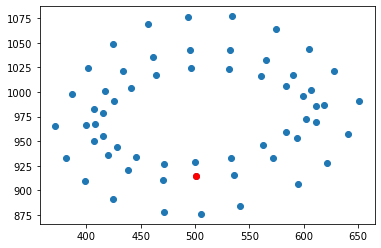

In [20]:
plt.scatter(x, y)
ix = 25
plt.scatter(ground2[0][0, ix*2], ground2[0][0, ix*2 + 1], c = "red")